## **1. Import libraries and configure visualization**


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
import warnings

# Set global style for plots
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")




## **2. Load and visualize financial time series (base 100)**

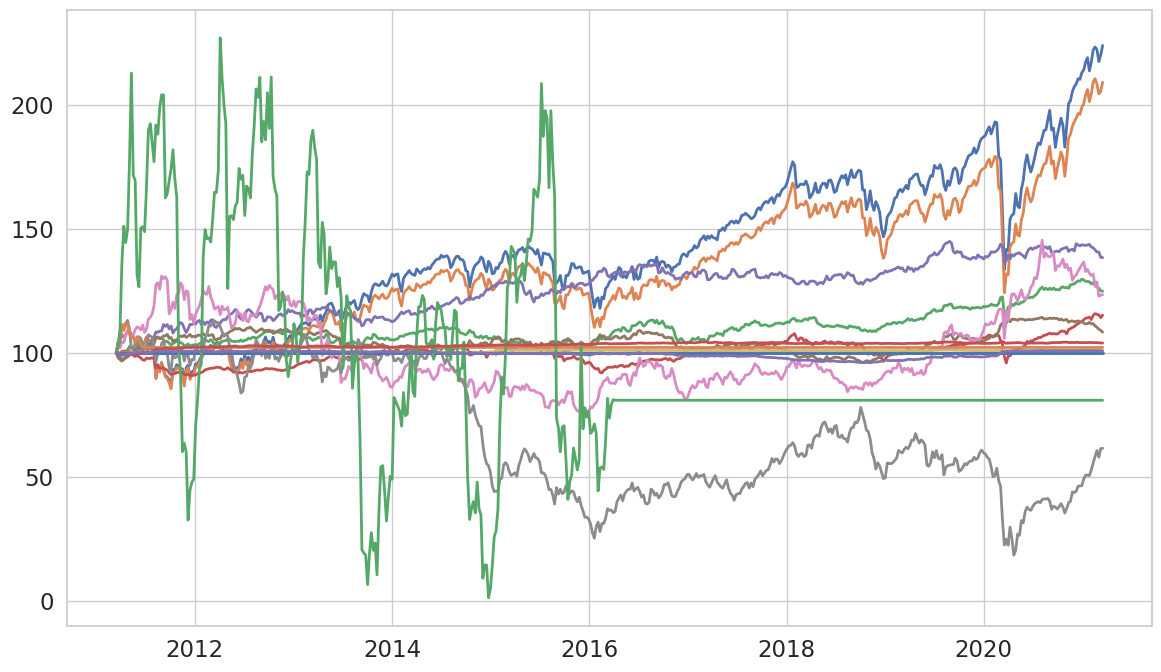

In [3]:
# === SETUP ===

# Define the local path to the Excel dataset stored on Google Drive
file_path = '/kaggle/input/portfolioreplica/Dataset3_PortfolioReplicaStrategy.xlsx'


# === METADATA EXTRACTION ===

# Extract full asset names from row 4 (Excel is 1-indexed; pandas is 0-indexed)
full_names = pd.read_excel(file_path, header=None, skiprows=3, nrows=1).iloc[0].tolist()[1:]

# Extract Bloomberg tickers from row 6
tickers = pd.read_excel(file_path, header=None, skiprows=5, nrows=1).iloc[0].tolist()[1:]

# === LOAD TIME SERIES ===

# Load the actual time series data starting from row 7
data = pd.read_excel(
    file_path,
    header=None,        # Do not use any row as header
    skiprows=6,         # Skip header rows
    parse_dates=[0],    # First column is parsed as datetime
    index_col=0         # Use the first column (dates) as the DataFrame index
)

# Rename columns using Bloomberg tickers
data.columns = tickers

# Create a dictionary mapping tickers to full asset names (for display purposes)
variable_info = dict(zip(tickers, full_names))

# Select the list of tickers to be analyzed (can be a subset)
target_indices = tickers

# === PLOT NORMALIZED TIME SERIES ===

# Initialize the figure
plt.figure(figsize=(14, 8))

# Loop through selected indices
for idx in target_indices:
    serie = data[idx].dropna()                      # Remove missing values
    norm = serie / serie.iloc[0] * 100              # Normalize series to base 100
    plt.plot(norm.index, norm, lw=2, label=f"{idx} ({variable_info.get(idx, idx)})")






## **3. Visualize and analyze selected target indices**

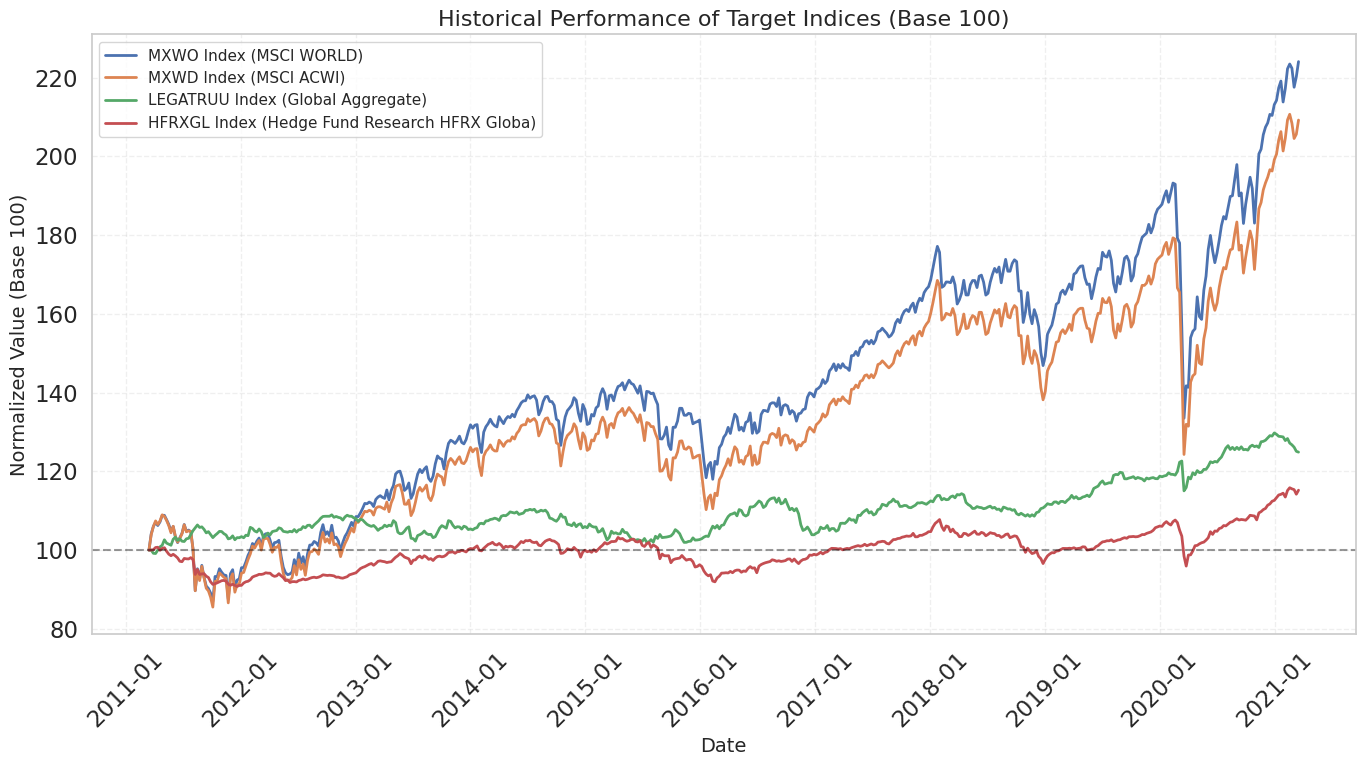

In [4]:
# Define specific indices to explore
target_indices = ['MXWO Index', 'MXWD Index', 'LEGATRUU Index', 'HFRXGL Index']

# Plot normalized historical price series (Base 100)
plt.figure(figsize=(14, 8))  # Set figure size for better readability
for idx in target_indices:
    # Normalize the series: base = 100 at first valid value
    normalized_series = data[idx] / data[idx].iloc[0] * 100
    plt.plot(
        normalized_series.index,
        normalized_series,
        linewidth=2,
        label=f"{idx} ({variable_info.get(idx, idx)})"
    )

# Customize the plot: titles, labels, and horizontal reference
plt.title('Historical Performance of Target Indices (Base 100)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Normalized Value (Base 100)', fontsize=14)
plt.axhline(y=100, color='black', linestyle='--', alpha=0.4)  # Reference line at base 100
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='best', fontsize=11, frameon=True)

# Improve x-axis formatting with monthly ticks and yearly locators
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compute weekly returns from normalized prices
returns = data[target_indices].pct_change().dropna()

# Annualization factor for weekly data
annual_factor = 52  # 52 trading weeks in a year

# Helper function to format floats as percentage strings
def format_pct(x):
    return f"{x * 100:.2f}%"

# Calculate performance statistics: return, risk, skewness, etc.
stats = pd.DataFrame({
    'Annualized Return': returns.mean() * annual_factor,
    'Annualized Volatility': returns.std() * np.sqrt(annual_factor),
    'Sharpe Ratio': (returns.mean() * annual_factor) / (returns.std() * np.sqrt(annual_factor)),
    'Max Drawdown': returns.apply(
        lambda x: (1 + x).cumprod().div((1 + x).cumprod().cummax()) - 1
    ).min(),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis()
})

# Format key statistics as percentage strings
for col in ['Annualized Return', 'Annualized Volatility', 'Max Drawdown']:
    stats[col] = stats[col].apply(format_pct)


## **4. Build custom target index and analyze correlation with futures constracts**

In [5]:
# === SUPPRESS SPECIFIC WARNINGS FOR CLEANER OUTPUT ===

# Ignore warnings where division by zero may occur during correlation or returns calculation
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

# === DEFINE SYNTHETIC BENCHMARK COMPOSITION ("Monster Index") ===

# The synthetic benchmark is composed of 25% Hedge Funds, 25% MSCI World, and 50% Global Bonds
index_components = {
    'HFRXGL Index': 0.25,    # Hedge Funds
    'MXWO Index':  0.25,     # MSCI World
    'LEGATRUU Index': 0.50   # Global Aggregate Bonds
}

# === COMPUTE WEEKLY RETURNS OF INDEX COMPONENTS ===

# Compute % changes for each component and drop missing values
component_returns = data[list(index_components.keys())].pct_change().dropna()

# Weighted sum of component returns to build the synthetic benchmark
weighted_returns = sum(component_returns[col] * w for col, w in index_components.items())
target_returns = weighted_returns.rename('Target_Index')  # Label the series

# === DEFINE FUTURES CONTRACTS USED FOR REPLICATION ===

# These are the candidate instruments (e.g., fixed income, equity, commodity futures)
futures_contracts = [
    'RX1 Comdty', 'TY1 Comdty', 'GC1 Comdty', 'CO1 Comdty',
    'ES1 Comdty', 'VG1 Comdty', 'NQ1 Comdty', 'LLL1 Comdty',
    'TP1 Comdty', 'DU1 Comdty', 'TU2 Comdty'
]

# === COMPUTE WEEKLY RETURNS OF FUTURES ===

# Percent changes for the replication instruments (drop initial NaNs)
futures_returns = data[futures_contracts].pct_change().dropna()

# === ALIGN DATES BETWEEN TARGET AND FUTURES ===

common_dates = futures_returns.index.intersection(target_returns.index)
futures_returns = futures_returns.loc[common_dates]
target_returns_aligned = target_returns.loc[common_dates]




## **5. Define model configuration**

In [6]:


from sklearn.linear_model import ElasticNet, Ridge  # Regularized linear models
from sklearn.preprocessing import MinMaxScaler      # Feature scaling
from itertools import product                       # Cartesian product for grid search
import warnings

# === SUPPRESS WARNINGS ===

# Ignore warnings (e.g., from model fitting or numerical issues) to keep output clean
warnings.filterwarnings('ignore')

# === ALIGN TARGET AND FEATURES ===

# Target vector (y): synthetic benchmark returns
y = target_returns_aligned

# Feature matrix (X): weekly returns of futures
X = futures_returns.loc[y.index]  # Ensure alignment by date

# Convert pandas objects to NumPy arrays for faster model processing
X_values = X.values
y_values = y.values
dates_array = X.index.to_numpy()  # Save date index for later time-aligned operations

# === HYPERPARAMETER GRIDS FOR MODEL SELECTION ===

# Elastic Net regularization ratio: 0 = Ridge, 1 = Lasso, in-between = ElasticNet
l1_ratios = [0, 0.2]

# Regularization strength (penalty size)
alphas = [0.01, 0.1]

# Rolling window sizes for model estimation (in weeks)
rolling_windows = [4, 13, 26, 52]  # Representing ~1 month, quarter, half-year, full year

# Kalman Filter hyperparameters:
# Q: process noise (controls how fast weights adapt)
# R: observation noise (controls how much trust is given to new data)
Qs = [0.01, 0.1]
Rs = [0.001, 0.01, 0.1]

# Number of past weeks used for beta-scaling (bias correction)
beta_windows = [2, 4, 13, 26]
""""
# === CONFIGURATION FOR VALUE AT RISK FILTERING ===

var_confidence = 0.01        # 1% VaR confidence level (i.e., 99% worst-case scenario)
var_horizon = 4              # Time horizon for VaR: 4 weeks (~1 month)
max_var_threshold = 0.08     # Reject portfolio allocations with VaR above 8%
min_var_threshold = 0.02     # Require at least 2% VaR to ensure some exposure

# === VAR FUNCTION (UNDER GAUSSIAN ASSUMPTION) ===

def calculate_var(returns, confidence=0.01, horizon=4):

    sigma = np.std(returns)                     # Estimate volatility
    z_score = stats.norm.ppf(confidence)        # Z-score from standard normal
    var = -z_score * sigma * np.sqrt(horizon)   # Scale by time and convert to positive
    return var

"""


'"\n# === CONFIGURATION FOR VALUE AT RISK FILTERING ===\n\nvar_confidence = 0.01        # 1% VaR confidence level (i.e., 99% worst-case scenario)\nvar_horizon = 4              # Time horizon for VaR: 4 weeks (~1 month)\nmax_var_threshold = 0.08     # Reject portfolio allocations with VaR above 8%\nmin_var_threshold = 0.02     # Require at least 2% VaR to ensure some exposure\n\n# === VAR FUNCTION (UNDER GAUSSIAN ASSUMPTION) ===\n\ndef calculate_var(returns, confidence=0.01, horizon=4):\n\n    sigma = np.std(returns)                     # Estimate volatility\n    z_score = stats.norm.ppf(confidence)        # Z-score from standard normal\n    var = -z_score * sigma * np.sqrt(horizon)   # Scale by time and convert to positive\n    return var\n\n'

## **6. Define a basic Kalman Filter for weight adaptation**



---

### Kalman Filter – Functional Overview

This class defines a Kalman Filter used to adaptively estimate portfolio weights over time.

* **`__init__`**: Initializes the filter with:

  * `dim_x`: number of assets (dimensions of the state vector).
  * `R`: observation noise variance (uncertainty in the benchmark return).
  * `Q`: process noise variance (uncertainty in weight evolution).
  * `P`: initial uncertainty of the weights.

* **`self.x`**: The state estimate (a vector of portfolio weights), initialized to small positive values.

* **`self.P`**: The state covariance matrix, representing uncertainty in the weights.

* **`self.F`**: Identity matrix used as the state transition model (weights assumed to follow a random walk).

* **`self.Q` and self.R\`**: Define the noise structure of the model (process vs observation).

---

#### `predict()`

* Projects the weights forward to the next period using:

  * `x = F @ x`: state projection (weights unchanged in expectation).
  * `P = F @ P @ F.T + Q`: increases uncertainty based on process noise.

---

#### `update(z, H)`

* Refines the weight estimates based on a new observation:

  * `z`: observed return of the target index.
  * `H`: current feature vector (asset returns).
  * Computes the prediction error (`y = z - H @ x`).
  * Calculates the Kalman gain `K`, which balances trust between model and new data.
  * Updates the weights `x = x + K @ y` and uncertainty `P`.

---

This filter is applied iteratively in the main loop to update weights at each time step using new observed returns.


In [7]:
class KalmanFilter:
    """
    Simple Kalman Filter for online estimation and weight adaptation.
    """

    def __init__(self, dim_x, R=1e-3, Q=1e-3, P=1.0):
        """
        Initialize the Kalman Filter.

        Parameters:
            dim_x (int): Number of state dimensions
            R (float): Observation noise variance
            Q (float): Process noise variance
            P (float): Initial state covariance
        """
        self.dim_x = dim_x
        self.x = np.ones((dim_x, 1)) * 0.01  # Initial state estimate
        self.P = P * np.eye(dim_x)          # Initial covariance matrix
        self.F = np.eye(dim_x)              # State transition matrix
        self.Q = Q * np.eye(dim_x)          # Process noise covariance
        self.R = R                          # Observation noise (scalar)

    def predict(self):
        """
        Predict the next state and covariance.
        """
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z, H):
        """
        Update the state estimate using observation z.

        Parameters:
            z (float): Observation (scalar)
            H (np.array): Observation model (1 x dim_x)
        """
        y = z - H @ self.x                        # Innovation (residual)
        S = H @ self.P @ H.T + self.R             # Innovation covariance
        K = self.P @ H.T / S                      # Kalman gain
        self.x = self.x + K @ y                   # Updated state estimate
        self.P = (np.eye(self.dim_x) - K @ H) @ self.P  # Updated covariance


## **7. Cross-validation for Kalman Filter with Ridge initialization**




This section performs **model selection for a Kalman Filter-based portfolio replicator**, using a rolling cross-validation framework and hyperparameter grid search.

---


#### 1. **Data Normalization**

* Inputs `X_train` and `X_val`, as well as targets `y_train` and `y_val`, are scaled using `MinMaxScaler`.
* This ensures numerical stability and compatibility with Ridge Regression and the Kalman filter.

#### 2. **Weight Initialization with Ridge Regression**

* The Ridge model is trained on scaled training data.
* The resulting coefficient vector is used as the **initial state estimate** for the Kalman filter.

#### 3. **Kalman Filter Setup**

* The Kalman Filter is initialized with:

  * `Q`: process noise (controls how much weights adapt over time).
  * `R`: observation noise (controls trust in new observations).
  * `P`: initial state covariance (default 1.0).
* The Ridge-initialized weights are used to set the initial filter state.

#### 4. **Validation Loop**

For each time step in the validation set:

* The Kalman filter makes a **prediction** and **updates** the weight vector using the new return observation.
* A **beta scaling** adjustment is applied:

  * Rolling beta is computed between predicted and true returns over a past window (`beta_window`).
  * Weights are scaled by the inverse of beta to improve tracking.

#### 5. **Store Results**

* The updated weights are saved at each step.
* The portfolio return (dot product of weights and input) is computed and stored.

---

### Evaluation Metrics

After the validation loop, several metrics are computed:

* **Annualized return and volatility** of the predicted series.
* **Sharpe Ratio**: return per unit of risk.
* **Tracking Error**: deviation from the target.
* **Information Ratio**: risk-adjusted performance relative to the target.
* **Correlation**: agreement between predicted and target series.

---

### Hyperparameter Grid Search

* A full grid search is performed over combinations of:

  * `alpha` (Ridge regularization)
  * `Q` and `R` (Kalman noise levels)
  * `beta_window` (length of beta scaling window)
  * `l1_ratio`, `rolling_window` (placeholders, not actively used here)
* For each configuration:

  * A **rolling train-validation split** is applied.
  * The validation procedure is repeated across time windows.
  * The **average correlation** is used as the selection metric.

---

### Output

* The best-performing configuration (with the highest average correlation across splits)




## **8. run_kf_Beta_Costs: Kalman Filter Portfolio Replication with Scaling and Costs**

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import numpy as np

# NOTE: Assumes you have already defined a class `KalmanFilter` with `.predict()` and `.update()` methods

def run_KF_Cross_Validation(l1_ratio, rolling_window, alpha, Q, R, beta_window, X_train, y_train, X_val, y_val):
    """
    Fit and validate a Kalman Filter model with Ridge initialization and beta scaling.

    Parameters:
        l1_ratio (float): Elastic Net mixing parameter (unused here, kept for generality).
        rolling_window (int): Not used in this function.
        alpha (float): Ridge regularization strength.
        Q (float): Kalman filter process noise (controls weight adaptivity).
        R (float): Kalman filter observation noise (controls trust in new data).
        beta_window (int): Rolling window size for beta-scaling.
        X_train (ndarray): Training features (2D).
        y_train (ndarray): Training target (1D).
        X_val (ndarray): Validation features (2D).
        y_val (ndarray): Validation target (1D).
    """
    weights_history = []         # Store weights across validation horizon
    replica_returns = []         # Store one-step-ahead predicted returns
    gross_exposures = []         # Not used here, could store |weights| sums
    var_values = []              # Not used here, placeholder for future VaR
    scaling_factors = []         # Not used here
    beta_scaling = 1             # Initial beta scaling factor (multiplicative)

    # === Normalize data (scale features between 0 and 1) ===
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

    # === Initialize weights using Ridge regression ===
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(X_train_scaled, y_train_scaled)
    initial_weights = ridge.coef_
    N = initial_weights.shape[0]  # Number of features

    # === Initialize Kalman Filter ===
    kf = KalmanFilter(dim_x=N, R=R, Q=Q, P=1.0)
    kf.x = initial_weights.reshape(-1, 1)  # Set initial state

    # === Validation Loop: One-step ahead prediction ===
    for t in range(len(y_val_scaled)):
        H_t = X_val_scaled[t].reshape(1, -1)   # Current input (row vector)
        y_t = y_val_scaled[t]                 # True value

        kf.predict()                          # Time update (prior)
        kf.update(y_t, H_t)                   # Measurement update (posterior)

        current_weights = kf.x.flatten()

        # === Beta scaling adjustment ===
        if len(replica_returns) >= beta_window:
            historical_replica = np.array(replica_returns[-beta_window:])
            historical_target = np.array(y_values[t - beta_window:t])

            target_var = np.var(historical_target)
            if target_var > 1e-6:  # Avoid divide-by-zero
                beta = np.cov(historical_replica, historical_target)[0, 1] / target_var
                beta = np.clip(beta, 0.5, 2.0)  # Prevent instability
                beta_scaling = 1.0 / beta

        current_weights *= beta_scaling  # Apply scaling to weights

        # === Store weights and compute prediction ===
        weights_history.append(current_weights)
        replica_ret = np.dot(X_val_scaled[t], current_weights)
        replica_returns.append(replica_ret)

    # === Compute performance metrics ===
    replica_returns = np.array(replica_returns)
    aligned_target = y_val_scaled

    # Annualized mean and volatility
    replica_mean_return = replica_returns.mean() * 52
    target_mean_return = aligned_target.mean() * 52

    replica_vol = replica_returns.std() * np.sqrt(52)
    target_vol = aligned_target.std() * np.sqrt(52)

    replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else 0
    target_sharpe = target_mean_return / target_vol if target_vol > 0 else 0

    # Tracking error and information ratio
    tracking_error = (replica_returns - aligned_target).std() * np.sqrt(52)
    information_ratio = (
        (replica_mean_return - target_mean_return) / tracking_error
        if tracking_error > 0 else 0
    )

    # Pearson correlation between predictions and target
    correlation = np.mean(np.corrcoef(replica_returns, aligned_target))

    return {
        'replica_sharpe': replica_sharpe,
        'replica_returns': replica_returns,
        'information_ratio': information_ratio,
        'tracking_error': tracking_error,
        'correlation': correlation,
        'weights_history': weights_history
    }

# === GRID SEARCH FOR BEST KALMAN CONFIGURATION ===

train_window = 52   # Length of training window (e.g., 1 year)
val_window = 52     # Length of validation window (e.g., 1 year)

best_metrics = {}   # Store best performance result
best_params = None  # Store corresponding parameters

# Full grid search across all hyperparameter combinations
for l1_ratio, rolling_window, alpha, Q, R, beta_window in product(
        l1_ratios, rolling_windows, alphas, Qs, Rs, beta_windows):

    metrics = []

    # Rolling train/val split
    for i in range(len(X_values) - train_window - val_window):
        train_start_idx = i
        train_end_idx = i + train_window
        val_start_idx = train_end_idx
        val_end_idx = val_start_idx + val_window

        X_train = X_values[train_start_idx:train_end_idx]
        y_train = y_values[train_start_idx:train_end_idx]
        X_val = X_values[val_start_idx:val_end_idx]
        y_val = y_values[val_start_idx:val_end_idx]

        # Run Kalman model on current split
        result = run_KF_Cross_Validation(
            l1_ratio, rolling_window, alpha, Q, R, beta_window,
            X_train, y_train, X_val, y_val
        )

        # Metric to maximize: currently correlation
        metrics.append(result['correlation'])

    avg_metric = np.mean(metrics)

    # Update best parameters if current average is better
    if not best_metrics or avg_metric > best_metrics.get('avg_metric', float('-inf')):
        best_metrics = {
            'avg_metric': avg_metric,
            'l1_ratio': l1_ratio,
            'rolling_window': rolling_window,
            'alpha': alpha,
            'Q': Q,
            'R': R,
            'beta_window': beta_window
        }
        best_params = (l1_ratio, alpha, Q, R)

# Output the best configuration
print("Best metrics:")
print(best_metrics)
print("Best params:")
print(best_params)


**The previous code takes 27 minutes to run. These are the best metrics obtained earlier**


In [9]:
best_metrics = {
            'avg_metric': 0.816,
            'l1_ratio': 0,
            'rolling_window': 4,
            'alpha': 0.1,
            'Q': 0.1,
            'R': 0.001,
            'beta_window': 26
        }

### **Kalman Filter with Beta Scaling, Buffering, and Transaction Cost Simulation**




This function extends the standard Kalman Filter portfolio replication pipeline by introducing several mechanisms to better reflect real-world portfolio management constraints.

* **Data normalization** is applied to both features and target returns using MinMax scaling.
* **Initial portfolio weights** are estimated via Ridge regression and used to initialize the Kalman Filter’s internal state.
* The model then iteratively updates the portfolio weights using the Kalman update rule in a rolling window framework.

The key additions in this version are:

1. **Transaction Cost Modeling**
   A fixed cost per trade is subtracted from the portfolio return whenever a reallocation occurs. This simulates execution frictions faced in real markets.

2. **Rebalancing Buffer (Thresholding)**
   If the change in weights compared to the previous period is below a predefined threshold, no trades are executed and the previous allocation is reused. This reduces unnecessary rebalancing and associated costs.

3. **Beta Scaling**
   A rolling regression is used to align the volatility sensitivity (beta) of the replica portfolio with that of the target. This controls the risk exposure over time by scaling the weights.

4. **Tracking of Intermediate States**
   The function stores multiple return series:

   * Without scaling,
   * With scaling but no costs,
   * With both scaling and transaction costs.

At the end of the loop, standard performance metrics (Sharpe ratio, tracking error, drawdown, correlation, etc.) are computed and returned, along with the series of cumulative returns and weights over time.

This implementation is used to evaluate how well the Kalman-based strategy can replicate a benchmark portfolio **under realistic trading constraints**.


In [10]:
# Function to run a single configuration with normalized returns and proper VaR scaling
def run_kf_Beta_Costs(l1_ratio, rolling_window, alpha, Q, R, beta_window, buffering, cost):
    # Initialize arrays to store results
    weights_history = []  # Store weights over time
    replica_returns = []  # Store replica portfolio returns
    target_dates = []  # Store dates for plotting
    gross_exposures = []  # Store gross exposure over time
    var_values = []  # Store VaR values over time
    scaling_factors = []  # Store scaling factors applied

    weights_history_NoScaling = []  # Store weights over time
    replica_mean_return_NoScaling = []

    weights_history_Scaling_NoCosts = []
    replica_mean_return_Scaling_NoCosts = []
    
    Beta_Scaling = [] # Store Beta over time
    beta_scaling = 1

    weight_change_threshold= buffering
    transaction_cost_per_trade = cost  
    transaction_cost = 0

     # Initial weight from EN to initialize Kalman Filter later
    init_weights = None
    # Loop through the data using a rolling window approach as explained before
    for i in range(len(X) - rolling_window - 1):
        # Define training window
        start_idx = i
        end_idx = i + rolling_window

        # Extract training data
        X_train = X_values[start_idx:end_idx]
        y_train = y_values[start_idx:end_idx]

        # Normalize the training data using MinMaxScaler
        scaler_X = MinMaxScaler()
        X_train_normalized = scaler_X.fit_transform(X_train)

        # Normalize target
        scaler_y = MinMaxScaler()
        y_train_normalized = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

        # INIZIA PARTE AGGIUNTA
        # Initialize Kalman Filter on first pass
        if init_weights is None:
            ridge = Ridge(alpha=alpha, fit_intercept=False)
            ridge.fit(X_train_normalized, y_train_normalized)
            normalized_weights = ridge.coef_
            original_weights = normalized_weights / scaler_X.scale_

            previous_weights = np.zeros_like(original_weights)  ######transaction cost

            # Initialize Kalman filter with Ridge weights
            N = original_weights.shape[0]
            kf = KalmanFilter(dim_x=N, R=R, Q=Q, P=1.0)
            kf.x = (original_weights.reshape(-1, 1) + 0.01)  # Small positive bias
            init_weights = original_weights.copy()

        # Update Kalman H to current feature vector
        H = X_values[end_idx].reshape(1, -1)
        y_t = np.array([[y_values[end_idx]]])

        kf.predict()
        kf.update(y_t, H)

        kalman_weights = kf.x.flatten()

        # FINE PARTE AGGIUNTA


        # Default scaling factor
        var_scaling = 1.0
        #vol_scaling = 1.0
        # If we have enough historical data, calculate VaR and scale if needed
        if len(replica_returns) >= 12:  # Need some history to calculate VaR...

            # Volatility targeting
            #recent_returns = np.array(replica_returns[-12:])
            #realized_vol = recent_returns.std() * np.sqrt(52)
            #target_vol = 0.10  # set your target volatility here
            #if realized_vol > 0:
            #    vol_scaling = target_vol / realized_vol


            # Calculate historical replica returns using current weights
            historical_returns = []
            for j in range(max(0, len(replica_returns)-52), len(replica_returns)):
                # Get historical futures returns for this period
                hist_returns = X_values[end_idx-(len(replica_returns)-j)]
                # Calculate weighted return
                weighted_return = np.dot(hist_returns, kalman_weights)
                historical_returns.append(weighted_return)

        # Combine scaling factors
        #total_scaling = vol_scaling * var_scaling

        kalman_weights *= var_scaling

        # Store scaling factor
        scaling_factors.append(var_scaling)

       

        # METTERE BETA SCALING
        if len(replica_returns) >= beta_window:
            # Construct aligned slices for beta calc
            historical_replica = np.array(replica_returns[-beta_window:])
            historical_target = np.array(y_values[end_idx - beta_window:end_idx])

            target_var = np.var(historical_target)
            if target_var > 1e-6:
                beta = np.cov(historical_replica, historical_target)[0, 1] / target_var
                beta = np.clip(beta, 0.5, 2.0)  # Avoid instability
                beta_scaling = 1.0 / beta

        # Store the weights after scaling
        weights_history_NoScaling.append(kalman_weights)

        replica_mean_return_NoScaling.append(np.dot(X_values[end_idx], kalman_weights))

        # Store Beta Scaling
        Beta_Scaling.append(beta_scaling)

        # Apply beta scaling to weights
        kalman_weights *= beta_scaling
        
        gross_exposures.append(np.sum(np.abs(kalman_weights)))

        # Store the weights after scaling
        weights_history_Scaling_NoCosts.append(kalman_weights)

        replica_mean_return_Scaling_NoCosts.append(np.dot(X_values[end_idx], kalman_weights))
        # ==== BETA SCALING END

        # Store the weights after scaling
        weights_history.append(kalman_weights)

        # Calculate replica return for the next period (t+1)
        next_returns = X_values[end_idx]  # This is t+1

        # TRANS BUFFERING
        if previous_weights is not None:
            weight_change = np.abs(kalman_weights - previous_weights)
        if np.all(weight_change < weight_change_threshold):
            # Use scaled original weights with original returns
            replica_return = np.dot(next_returns, previous_weights)
    
            replica_returns.append(replica_return)

            previous_weights = kalman_weights.copy()
    
            # Store the date for t+1
            target_dates.append(dates_array[end_idx])
            continue


     

        # Check which assets had a change in position
        trades_executed = np.abs(kalman_weights - previous_weights) > 0
        num_trades = np.sum(trades_executed)

        # Apply fixed cost per trade
        transaction_cost = num_trades * transaction_cost_per_trade
        previous_weights = kalman_weights.copy()

        # Apply transaction cost to the return
        replica_return = np.dot(next_returns, kalman_weights) - transaction_cost


        replica_returns.append(replica_return)

        # Store the date for t+1
        target_dates.append(dates_array[end_idx])

    # Convert results to pandas series for easier analysis
    replica_returns_series = pd.Series(replica_returns, index=target_dates)

    replica_returns_series_NoScaling = pd.Series(replica_mean_return_NoScaling, index=target_dates)

    replica_returns_series_Scaling_NoCosts = pd.Series(replica_mean_return_Scaling_NoCosts, index=target_dates)

    # Calculate cumulative returns for both target and replica
    aligned_target = y.loc[replica_returns_series.index]
    cumulative_target = (1 + aligned_target).cumprod()
    cumulative_replica = (1 + replica_returns_series).cumprod()

    cumulative_replica_NoScaling = (1 + replica_returns_series_NoScaling).cumprod()
    
    cumulative_replica_Scaling_NoCosts = (1 + replica_returns_series_Scaling_NoCosts).cumprod()

    # Calculate performance metrics
    replica_mean_return = replica_returns_series.mean() * 52  # annualized
    target_mean_return = aligned_target.mean() * 52  # annualized

    replica_vol = replica_returns_series.std() * np.sqrt(52)  # annualized
    target_vol = aligned_target.std() * np.sqrt(52)  # annualized

    replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else 0
    target_sharpe = target_mean_return / target_vol if target_vol > 0 else 0

    # Calculate tracking error
    tracking_error = (replica_returns_series - aligned_target).std() * np.sqrt(52)
    information_ratio = (replica_mean_return - target_mean_return) / tracking_error if tracking_error > 0 else 0

    # Calculate drawdowns
    replica_drawdown = 1 - cumulative_replica / cumulative_replica.cummax()
    target_drawdown = 1 - cumulative_target / cumulative_target.cummax()

    # Calculate correlation
    correlation = replica_returns_series.corr(aligned_target)

    # Calculate average gross exposure
    avg_gross_exposure = np.mean(gross_exposures)

    # Calculate average VaR (excluding NaN values)
    avg_var = np.nanmean(var_values)

    # Return all metrics
    return {
        'l1_ratio': l1_ratio,
        'rolling_window': rolling_window,
        'alpha': alpha,
        'replica_return': replica_mean_return,
        'target_return': target_mean_return,
        'replica_vol': replica_vol,
        'target_vol': target_vol,
        'replica_sharpe': replica_sharpe,
        'target_sharpe': target_sharpe,
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'correlation': correlation,
        'max_drawdown': replica_drawdown.max(),
        'avg_gross_exposure': avg_gross_exposure,
        'avg_var': avg_var,
        'replica_returns': replica_returns_series,
        'aligned_target': aligned_target,
        'cumulative_replica': cumulative_replica,
        'cumulative_target': cumulative_target,
        'gross_exposures': gross_exposures,
        'scaling_factors': scaling_factors,
        'weights_history': weights_history,
        'Q': Q,
        'R': R,
        'replica_return_NoScaling': replica_mean_return_NoScaling,
        'beta': beta_window,
        'cumulative_replica_NoScaling_NoCosts': cumulative_replica_NoScaling,
        'cumulative_replica_Scaling_NoCosts': cumulative_replica_Scaling_NoCosts
    }





###  What’s New in `run_kf_Beta_Costs_Adapt`

This version of the Kalman-based replication function introduces one key change aimed at **better incorporating the impact of transaction costs directly into the model’s learning process**.

#### 1. Adaptive Target Update with Costs

Instead of applying transaction costs **only after** the Kalman weights are computed, this version **injects transaction costs directly into the observation used by the Kalman Filter**:

```python
y_t = np.array([[y_values[end_idx] + transaction_cost]])
```

This means:

* The Kalman filter is no longer estimating weights just to match the raw target return.
* It learns to match a *cost-adjusted target*, i.e., the return we would *actually* receive after accounting for slippage or execution cost.
* This anticipates and internalizes trading frictions during the filter's parameter updates, potentially yielding more realistic and cost-aware allocations.

---



In [11]:
# Function to run a single configuration with normalized returns and proper VaR scaling
def run_kf_Beta_Costs_Adapt(l1_ratio, rolling_window, alpha, Q, R, beta_window, buffering, cost):
    # Initialize arrays to store results
    weights_history = []  # Store weights over time
    replica_returns = []  # Store replica portfolio returns
    target_dates = []  # Store dates for plotting
    gross_exposures = []  # Store gross exposure over time
    var_values = []  # Store VaR values over time
    scaling_factors = []  # Store scaling factors applied

    weights_history_NoScaling = []  # Store weights over time
    replica_mean_return_NoScaling = []

    weights_history_Scaling_NoCosts = []
    replica_mean_return_Scaling_NoCosts = []
    
    Beta_Scaling = [] # Store Beta over time
    beta_scaling = 1

    weight_change_threshold= buffering
    transaction_cost_per_trade = cost  
    transaction_cost = 0

     # Initial weight from EN to initialize Kalman Filter later
    init_weights = None
    # Loop through the data using a rolling window approach as explained before
    for i in range(len(X) - rolling_window - 1):
        # Define training window
        start_idx = i
        end_idx = i + rolling_window

        # Extract training data
        X_train = X_values[start_idx:end_idx]
        y_train = y_values[start_idx:end_idx]

        # Normalize the training data using MinMaxScaler
        scaler_X = MinMaxScaler()
        X_train_normalized = scaler_X.fit_transform(X_train)

        # Normalize target
        scaler_y = MinMaxScaler()
        y_train_normalized = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

        # INIZIA PARTE AGGIUNTA
        # Initialize Kalman Filter on first pass
        if init_weights is None:
            ridge = Ridge(alpha=alpha, fit_intercept=False)
            ridge.fit(X_train_normalized, y_train_normalized)
            normalized_weights = ridge.coef_
            original_weights = normalized_weights / scaler_X.scale_

            previous_weights = np.zeros_like(original_weights) 

            # Initialize Kalman filter with Ridge weights
            N = original_weights.shape[0]
            kf = KalmanFilter(dim_x=N, R=R, Q=Q, P=1.0)
            kf.x = (original_weights.reshape(-1, 1) + 0.01)  # Small positive bias
            init_weights = original_weights.copy()

        # Update Kalman H to current feature vector
        H = X_values[end_idx].reshape(1, -1)
        y_t = np.array([[y_values[end_idx] + transaction_cost]])

        kf.predict()
        kf.update(y_t, H)

        kalman_weights = kf.x.flatten()

        # FINE PARTE AGGIUNTA

        # Default scaling factor
        var_scaling = 1.0
        #vol_scaling = 1.0
        # If we have enough historical data, calculate VaR and scale if needed
        if len(replica_returns) >= 12:  # Need some history to calculate VaR...

            # Calculate historical replica returns using current weights
            historical_returns = []
            for j in range(max(0, len(replica_returns)-52), len(replica_returns)):
                # Get historical futures returns for this period
                hist_returns = X_values[end_idx-(len(replica_returns)-j)]
                # Calculate weighted return
                weighted_return = np.dot(hist_returns, kalman_weights)
                historical_returns.append(weighted_return)

        # Combine scaling factors
        #total_scaling = vol_scaling * var_scaling

        kalman_weights *= var_scaling

        # Store scaling factor
        scaling_factors.append(var_scaling)

        # METTERE BETA SCALING

        if len(replica_returns) >= beta_window:
            # Construct aligned slices for beta calc
            historical_replica = np.array(replica_returns[-beta_window:])
            historical_target = np.array(y_values[end_idx - beta_window:end_idx])

            target_var = np.var(historical_target)
            if target_var > 1e-6:
                beta = np.cov(historical_replica, historical_target)[0, 1] / target_var
                beta = np.clip(beta, 0.5, 2.0)  # Avoid instability
                beta_scaling = 1.0 / beta

        # Store the weights after scaling
        weights_history_NoScaling.append(kalman_weights)

        replica_mean_return_NoScaling.append(np.dot(X_values[end_idx], kalman_weights))

        # Store Beta Scaling
        Beta_Scaling.append(beta_scaling)

        # Apply beta scaling to weights
        kalman_weights *= beta_scaling

        gross_exposure = np.sum(np.abs(kalman_weights))

        gross_exposures.append(gross_exposure)

        # Store the weights after scaling
        weights_history_Scaling_NoCosts.append(kalman_weights)

        replica_mean_return_Scaling_NoCosts.append(np.dot(X_values[end_idx], kalman_weights))
        # ==== BETA SCALING END

        # Store the weights after scaling
        weights_history.append(kalman_weights)

        # Calculate replica return for the next period (t+1)
        next_returns = X_values[end_idx]  # This is t+1

        # TRANS BUFFERING
        if previous_weights is not None:
            weight_change = np.abs(kalman_weights - previous_weights)
        if np.all(weight_change < weight_change_threshold):
            # Use scaled original weights with original returns
            replica_return = np.dot(next_returns, previous_weights)
    
            replica_returns.append(replica_return)

            previous_weights = kalman_weights.copy()
    
            # Store the date for t+1
            target_dates.append(dates_array[end_idx])
            continue


        

        # Check which assets had a change in position
        trades_executed = np.abs(kalman_weights - previous_weights) > 0
        num_trades = np.sum(trades_executed)

        # Apply fixed cost per trade
        transaction_cost = num_trades * transaction_cost_per_trade
        previous_weights = kalman_weights.copy()

        # Apply transaction cost to the return
        replica_return = np.dot(next_returns, kalman_weights) - transaction_cost

       

        replica_returns.append(replica_return)

        # Store the date for t+1
        target_dates.append(dates_array[end_idx])

    # Convert results to pandas series for easier analysis
    replica_returns_series = pd.Series(replica_returns, index=target_dates)

    replica_returns_series_NoScaling = pd.Series(replica_mean_return_NoScaling, index=target_dates)

    replica_returns_series_Scaling_NoCosts = pd.Series(replica_mean_return_Scaling_NoCosts, index=target_dates)

    # Calculate cumulative returns for both target and replica
    aligned_target = y.loc[replica_returns_series.index]
    cumulative_target = (1 + aligned_target).cumprod()
    cumulative_replica = (1 + replica_returns_series).cumprod()

    cumulative_replica_NoScaling = (1 + replica_returns_series_NoScaling).cumprod()
    
    cumulative_replica_Scaling_NoCosts = (1 + replica_returns_series_Scaling_NoCosts).cumprod()

    # Calculate performance metrics
    replica_mean_return = replica_returns_series.mean() * 52  # annualized
    target_mean_return = aligned_target.mean() * 52  # annualized

    replica_vol = replica_returns_series.std() * np.sqrt(52)  # annualized
    target_vol = aligned_target.std() * np.sqrt(52)  # annualized

    replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else 0
    target_sharpe = target_mean_return / target_vol if target_vol > 0 else 0

    # Calculate tracking error
    tracking_error = (replica_returns_series - aligned_target).std() * np.sqrt(52)
    information_ratio = (replica_mean_return - target_mean_return) / tracking_error if tracking_error > 0 else 0

    # Calculate drawdowns
    replica_drawdown = 1 - cumulative_replica / cumulative_replica.cummax()
    target_drawdown = 1 - cumulative_target / cumulative_target.cummax()

    # Calculate correlation
    correlation = replica_returns_series.corr(aligned_target)

    # Calculate average gross exposure
    avg_gross_exposure = np.mean(gross_exposures)

    # Calculate average VaR (excluding NaN values)
    avg_var = np.nanmean(var_values)

    # Return all metrics
    return {
        'l1_ratio': l1_ratio,
        'rolling_window': rolling_window,
        'alpha': alpha,
        'replica_return': replica_mean_return,
        'target_return': target_mean_return,
        'replica_vol': replica_vol,
        'target_vol': target_vol,
        'replica_sharpe': replica_sharpe,
        'target_sharpe': target_sharpe,
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'correlation': correlation,
        'max_drawdown': replica_drawdown.max(),
        'avg_gross_exposure': avg_gross_exposure,
        'avg_var': avg_var,
        'replica_returns': replica_returns_series,
        'aligned_target': aligned_target,
        'cumulative_replica': cumulative_replica,
        'cumulative_target': cumulative_target,
        'gross_exposures': gross_exposures,
        'scaling_factors': scaling_factors,
        'weights_history': weights_history,
        'Q': Q,
        'R': R,
        'replica_return_NoScaling': replica_mean_return_NoScaling,
        'beta': beta_window,
        'cumulative_replica_NoScaling_NoCosts': cumulative_replica_NoScaling,
        'cumulative_replica_Scaling_NoCosts': cumulative_replica_Scaling_NoCosts
    }



## **9.Performance Evaluation and Summary Statistics for the Best Kalman Configuration**

In [12]:
best_kf = run_kf_Beta_Costs(best_metrics['l1_ratio'], best_metrics['rolling_window'], best_metrics['alpha'], best_metrics['Q'], best_metrics['R'], best_metrics['beta_window'], 0.05, 0.00005)
noBuff = run_kf_Beta_Costs(best_metrics['l1_ratio'], best_metrics['rolling_window'], best_metrics['alpha'], best_metrics['Q'], best_metrics['R'], best_metrics['beta_window'], 0, 0.00005)
adapted = run_kf_Beta_Costs_Adapt(best_metrics['l1_ratio'], best_metrics['rolling_window'], best_metrics['alpha'], best_metrics['Q'], best_metrics['R'], best_metrics['beta_window'], 0.05, 0.00005)

## **10. Evaluate and Visualize the Performance of the Best Kalman Configuration**

In [13]:
# Utility function to print metrics from a model run
def print_kf_metrics(name, result):
    print(f"=== {name} ===")
    print(f"Annualized Replica Return:   {result['replica_return']:.4%}")
    print(f"Annualized Target Return:    {result['target_return']:.4%}")
    print(f"Annualized Replica Vol:      {result['replica_vol']:.4%}")
    print(f"Annualized Target Vol:       {result['target_vol']:.4%}")
    print(f"Replica Sharpe Ratio:        {result['replica_sharpe']:.4f}")
    print(f"Target Sharpe Ratio:         {result['target_sharpe']:.4f}")
    print(f"Tracking Error:              {result['tracking_error']:.4%}")
    print(f"Information Ratio:           {result['information_ratio']:.4f}")
    print(f"Correlation:                 {result['correlation']:.4f}")
    print(f"Max Drawdown:                {result['max_drawdown']:.4%}")
    print(f"Average Gross Exposure:      {result['avg_gross_exposure']:.4f}")
    print(f"Average VaR:                 {result['avg_var']:.4%}")
    print()

# Print all models
print_kf_metrics("Standard Kalman", best_kf)
print_kf_metrics("No Buffering", noBuff)
print_kf_metrics("Cost-Adjusted (Adapted)", adapted)


=== Standard Kalman ===
Annualized Replica Return:   0.2292%
Annualized Target Return:    3.6649%
Annualized Replica Vol:      6.3075%
Annualized Target Vol:       5.5829%
Replica Sharpe Ratio:        0.0363
Target Sharpe Ratio:         0.6565
Tracking Error:              3.9975%
Information Ratio:           -0.8595
Correlation:                 0.7806
Max Drawdown:                26.5380%
Average Gross Exposure:      2.4819
Average VaR:                 nan%

=== No Buffering ===
Annualized Replica Return:   -0.8879%
Annualized Target Return:    3.6649%
Annualized Replica Vol:      5.1846%
Annualized Target Vol:       5.5829%
Replica Sharpe Ratio:        -0.1713
Target Sharpe Ratio:         0.6565
Tracking Error:              1.8425%
Information Ratio:           -2.4710
Correlation:                 0.9441
Max Drawdown:                24.5594%
Average Gross Exposure:      2.3568
Average VaR:                 nan%

=== Cost-Adjusted (Adapted) ===
Annualized Replica Return:   2.0793%
Annual

## **Cumulative Returns – No Beta & No Costs vs. Beta & No Costs**

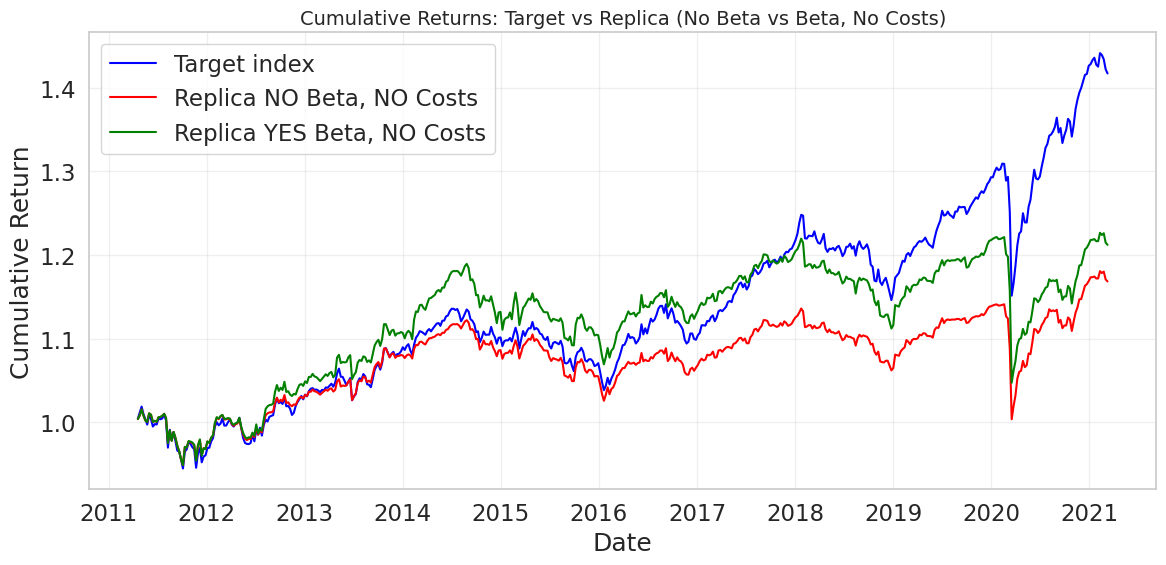

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(best_kf['cumulative_target'], label='Target index', color='blue')
plt.plot(best_kf['cumulative_replica_NoScaling_NoCosts'], label='Replica NO Beta, NO Costs', color='red')
plt.plot(best_kf['cumulative_replica_Scaling_NoCosts'], label='Replica YES Beta, NO Costs', color='green')
plt.title('Cumulative Returns: Target vs Replica (No Beta vs Beta, No Costs)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


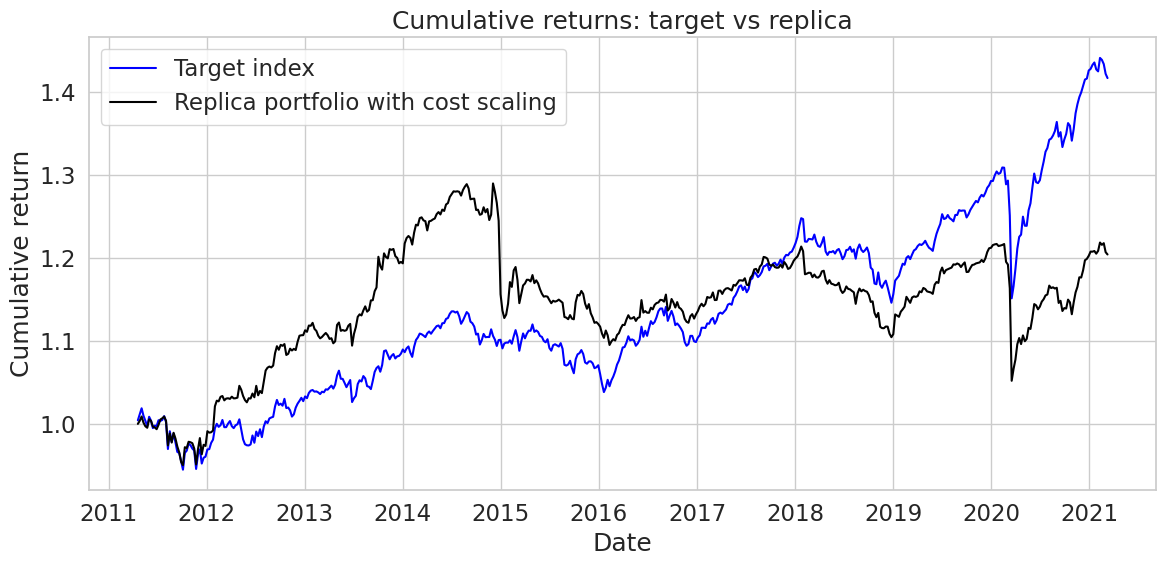

In [15]:
# Plot cumulative returns Beta No Costs - Beta Costs
plt.figure(figsize=(12, 6))
plt.plot(best_kf['cumulative_target'], label='Target index', color='blue')
plt.plot(adapted['cumulative_replica'], label='Replica portfolio with cost scaling', color='black')
plt.title('Cumulative returns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Cumulative Returns – Beta No Costs vs. Beta + Costs**

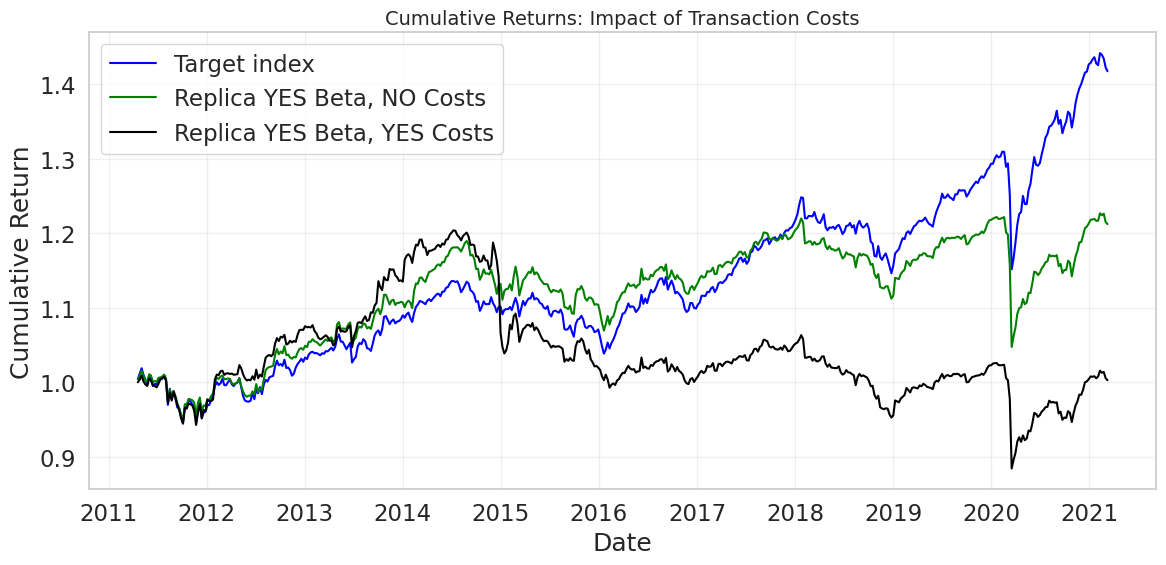

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(best_kf['cumulative_target'], label='Target index', color='blue')
plt.plot(best_kf['cumulative_replica_Scaling_NoCosts'], label='Replica YES Beta, NO Costs', color='green')
plt.plot(best_kf['cumulative_replica'], label='Replica YES Beta, YES Costs', color='black')
plt.title('Cumulative Returns: Impact of Transaction Costs', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## **Weekly Performance Analysis & Rolling Correlation**

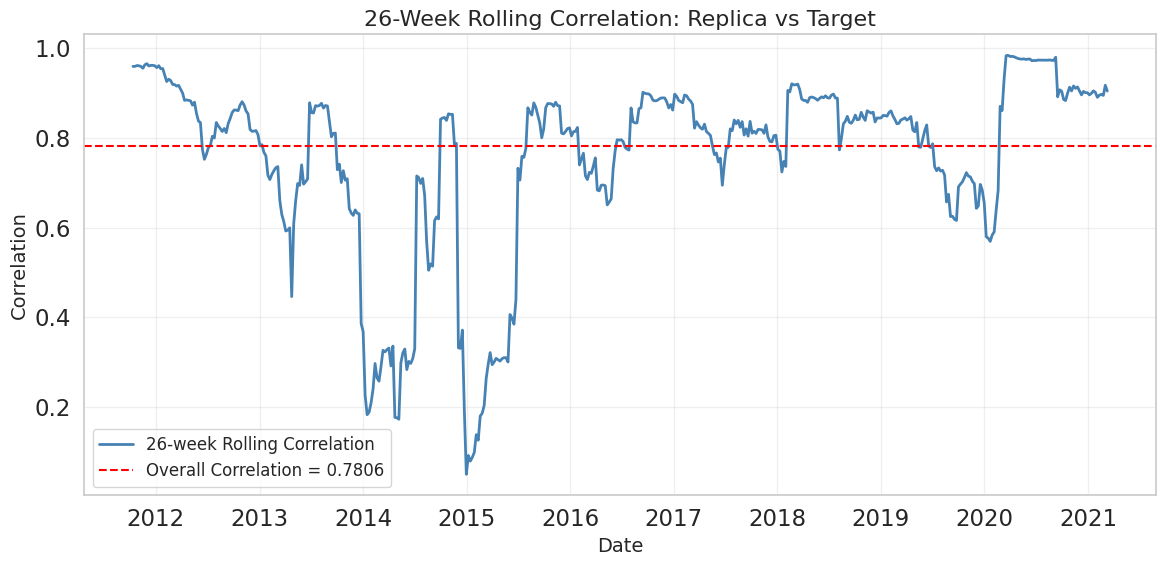

In [18]:
# === Rolling Correlation (26-week window) ===
plt.figure(figsize=(12, 6))
rolling_corr = best_kf['replica_returns'].rolling(window=26).corr(best_kf['aligned_target'])

plt.plot(
    rolling_corr,
    color='steelblue',
    linewidth=2,
    label='26-week Rolling Correlation'
)
plt.axhline(
    y=best_kf['correlation'],
    color='red',
    linestyle='--',
    linewidth=1.5,
    label=f'Overall Correlation = {best_kf["correlation"]:.4f}'
)

plt.title('26-Week Rolling Correlation: Replica vs Target', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## **11. Ensemble Linear Models with Bias-Correction and Grid Search**


This code implements a complete **ensemble-based portfolio replication** pipeline using multiple linear regression models in a rolling window framework. It builds a composite signal from different estimators, regularizes it, and corrects for systematic bias to improve tracking accuracy.

#### 1. **Model Training in Rolling Windows**

The core function `compute_weights_linear_model()` trains a given linear model (e.g., OLS, Ridge, Lasso, ElasticNet) over a **rolling window** of fixed size. For each step in time:

* It fits the model on the past `window` observations of the feature matrix `X` (asset returns) and the target `y` (index returns).
* It extracts the model coefficients and **normalizes** them to have unit gross exposure, making the portfolio comparable over time.

#### 2. **Running the Full Ensemble Pipeline**

The `run_pipeline()` function orchestrates the full process for a given set of hyperparameters:

* **Step 1**: Compute time-varying portfolio weights for each base model (OLS, Ridge, Lasso, ENet) using `compute_weights_linear_model()`.
* **Step 2**: Align all the resulting weight matrices to a common time index (to ensure valid averaging).
* **Step 3**: Average the weights equally across all models to obtain the **raw ensemble portfolio**.
* **Step 4**: Apply **shrinkage toward equal weights**: this regularization helps reduce overfitting and improve robustness.

  $$
  w_{\text{shrink}} = \alpha_{\text{shrink}} \cdot w_{\text{equal}} + (1 - \alpha_{\text{shrink}}) \cdot w_{\text{ensemble}}
  $$
* **Step 5**: Compute the **replica returns** by taking the dot product between weights and asset returns.
* **Step 6**: Perform **bias correction**: a rolling mean of past prediction errors is added to the return, lagged by one period, to reduce persistent under- or over-estimation.
* **Step 7**: Finally, compute the **correlation** between the bias-corrected replica return and the target return.

#### 3. **Hyperparameter Grid Search**

A large grid of possible hyperparameter combinations is defined:

* Rolling window sizes
* Regularization strengths for Ridge, Lasso, and ENet
* Shrinkage factor toward equal weighting
* Bias correction window

A **grid search** explores all combinations using `itertools.product()`, running the full pipeline for each configuration and tracking the one that yields the **highest correlation** with the benchmark.


In [ ]:
import numpy as np
import pandas as pd
import itertools
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.base import clone



# --- Function to compute model weights in rolling window fashion ---
def compute_weights_linear_model(model, X, y, window):
    """
    Fits the provided linear model in a rolling window and returns normalized weights.
    """
    weights, dates = [], X.index[window:]
    for t in range(window, len(X)):
        X_win, y_win = X.iloc[t-window:t].values, y.iloc[t-window:t].values
        m = clone(model).fit(X_win, y_win)
        w = m.coef_ / np.sum(np.abs(m.coef_))  # Normalize to unit gross exposure
        weights.append(w)
    return pd.DataFrame(weights, index=dates, columns=X.columns)


# --- Main pipeline for ensemble construction ---
def run_pipeline(params):
    """
    Runs the full ensemble pipeline: fit models, average, apply shrinkage and bias correction.
    Returns correlation with target.
    """

    # 1) Compute base model weights using rolling window regression
    w_ols   = compute_weights_linear_model(LinearRegression(fit_intercept=False), X, y, params['window'])
    w_ridge = compute_weights_linear_model(Ridge(alpha=params['alpha_ridge'], fit_intercept=False), X, y, params['window'])
    w_lasso = compute_weights_linear_model(Lasso(alpha=params['alpha_lasso'], fit_intercept=False), X, y, params['window'])
    w_enet  = compute_weights_linear_model(ElasticNet(alpha=params['alpha_enet'], l1_ratio=params['l1_ratio'], fit_intercept=False), X, y, params['window'])

    # 2) Align all weight DataFrames on common index
    idx = w_ols.index.intersection(w_ridge.index).intersection(w_lasso.index).intersection(w_enet.index)
    w_dict = {
        'OLS': w_ols.loc[idx],
        'Ridge': w_ridge.loc[idx],
        'Lasso': w_lasso.loc[idx],
        'ENet': w_enet.loc[idx]
    }

    # 3) Equal-weight ensemble of all models
    w_adapt = pd.concat(w_dict.values(), axis=1).groupby(level=0, axis=1).mean().loc[idx]

    # 4) Shrink weights toward equal weights (ridge-like regularization)
    w_eq = pd.DataFrame(1/w_adapt.shape[1], index=idx, columns=w_adapt.columns)
    w_shrink = params['alpha_shrink'] * w_eq + (1 - params['alpha_shrink']) * w_adapt

    # 5) Replica returns (dot product of weights × asset returns)
    r_shrink = (w_shrink * X.loc[idx]).sum(axis=1)

    # 6) Bias correction using rolling mean of residuals (lagged)
    err = y.loc[idx] - r_shrink
    bias = err.rolling(params['window_bc']).mean().shift(1).fillna(0)
    r_final = r_shrink + bias  # Add predicted bias

    # 7) Correlation with target over aligned dates
    common = r_final.index.intersection(y.index)
    return r_final.loc[common].corr(y.loc[common])


# --- Hyperparameter grid ---
param_grid = {
    'window':       [7, 13, 26],      # Rolling window size for fitting models
    #'window_perf':  [26, 52],          # Not used in this code (reserved for future ensemble validation)
    #'window_fit':   [52],         # Not used in this code (reserved for future stacking models)
    'alpha_ridge':  [0.1, 1.0, 10.0],  # Ridge regularization
    'alpha_lasso':  [0.01, 0.1, 1.0],  # Lasso regularization
    'alpha_enet':   [0.01, 0.1, 1.0],  # ElasticNet regularization
    'l1_ratio':     [0.2, 0.5],   # L1/L2 mix for ElasticNet
    #'alpha_meta':   [0.1, 1.0],        # Not used (meta-model shrinkage in stacking)
    'alpha_shrink': [0.1, 0.3],   # Shrinkage parameter toward equal-weight portfolio
    'window_bc':    [13, 52]           # Window size for rolling bias correction
}


# --- Grid Search to maximize correlation ---
best_score = -np.inf
best_params = None
keys = list(param_grid.keys())

# Iterate over all combinations of parameters
for values in itertools.product(*param_grid.values()):
    params = dict(zip(keys, values))
    corr = run_pipeline(params)
    if corr > best_score:
        best_score, best_params = corr, params

# Output best configuration
print("Best correlation:", best_score)
print("Best parameters:", best_params)


**The previous code reguire more then 5 hours to run, that's why we fixed the best parameters computed previuolsy in the following codes**

## **11. Rolling Linear Model Weights and Equal-Weight Ensemble**



### **Purpose of the Code**

This code builds rolling portfolios using different linear regression models (OLS, Ridge, Lasso, Elastic Net). At each step, the model fits a linear regression over a rolling window of asset returns (`X`) and a target return (`y`), computes normalized portfolio weights, and then combines them into an equal-weighted ensemble.

---

### **1. Core Function: `compute_weights_linear_model`**

This function performs rolling regression with any scikit-learn linear model and returns normalized portfolio weights.

**Parameters:**

* `model`: A scikit-learn linear model (e.g., `Ridge(alpha=1.0)`).
* `X`: A `DataFrame` of features, typically asset or futures returns.
* `y`: A `Series` of target returns (e.g., index to replicate).
* `window`: Rolling window size (e.g., 52 weeks).

**What it does:**

* Slides a window across time.
* Trains the model using `X` and `y` within that window.
* Extracts model coefficients (weights).
* Normalizes weights so that `sum(abs(weights)) = 1`, enforcing gross exposure neutrality.

**Returns:**

* A `DataFrame` of rolling portfolio weights indexed by date.

---

### **2. Wrapper Functions for Specific Models**

These are simplified functions for running the core routine with commonly used models and parameters:

* `weights_ols(...)`: Ordinary Least Squares (no regularization).
* `weights_ridge(...)`: Ridge regression (L2 penalty).
* `weights_lasso(...)`: Lasso regression (L1 penalty).
* `weights_elasticnet(...)`: Elastic Net regression (combined L1 + L2).

These wrappers call `compute_weights_linear_model(...)` with appropriate model objects and parameters.

---

### **3. Function: `ensemble_equal`**

This function combines the model-specific weight matrices into a single ensemble by averaging them equally.

**Parameters:**

* `weights_dict`: A dictionary where keys are model names and values are `DataFrames` of rolling weights.

**What it does:**

* Concatenates the weights across models.
* Computes the row-wise average to get the final ensemble weights.

**Returns:**

* A `DataFrame` containing the average (equal-weighted) portfolio weights across all base models.







In [19]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# --- Core Rolling Estimation Function ---
def compute_weights_linear_model(model, X: pd.DataFrame, y: pd.Series, window: int):
    """
    Fits a linear model in a rolling window over time and returns normalized weights.

    Parameters:
        model: Scikit-learn linear model (e.g., Ridge, Lasso, OLS)
        X: DataFrame of features (e.g., futures returns)
        y: Series of target values (e.g., target index returns)
        window: Rolling window size (e.g., 52 weeks)

    Returns:
        DataFrame of normalized portfolio weights, indexed by date
    """
    weights = []
    dates = X.index[window:]  # Dates aligned to end of each window

    for t in range(window, len(X)):
        # Select rolling window slice
        X_win = X.iloc[t-window:t].values
        y_win = y.iloc[t-window:t].values

        # Clone model to avoid side effects and fit
        m = clone(model).fit(X_win, y_win)
        w = m.coef_

        # Normalize to ensure sum(abs(w)) = 1 (long/short portfolio)
        w = w / np.sum(np.abs(w))
        weights.append(w)

    return pd.DataFrame(weights, index=dates, columns=X.columns)


# --- Wrappers for specific models with typical hyperparameters ---
def weights_ols(X, y, window=52):
    """
    Ordinary Least Squares (no regularization).
    """
    return compute_weights_linear_model(LinearRegression(fit_intercept=False), X, y, window)

def weights_ridge(X, y, window=52, alpha=1.0):
    """
    Ridge regression (L2 regularization).
    """
    return compute_weights_linear_model(Ridge(alpha=alpha, fit_intercept=False), X, y, window)

def weights_lasso(X, y, window=52, alpha=0.1):
    """
    Lasso regression (L1 regularization).
    """
    return compute_weights_linear_model(Lasso(alpha=alpha, fit_intercept=False), X, y, window)

def weights_elasticnet(X, y, window=52, alpha=0.1, l1_ratio=0.5):
    """
    Elastic Net regression (combination of L1 and L2).
    """
    return compute_weights_linear_model(
        ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=False),
        X, y, window
    )


# --- Simple Ensemble (Equal Weighting) ---
def ensemble_equal(weights_dict):
    """
    Averages multiple model weights with equal contribution.

    Parameters:
        weights_dict: Dictionary of DataFrames {model_name: weights_df}

    Returns:
        DataFrame of average weights across models
    """
    dfs = list(weights_dict.values())

    # Concatenate all weights and compute row-wise mean (across models)
    return pd.concat(dfs, axis=1).groupby(level=0, axis=1).mean()

## **Compute the models weights**

In [21]:
# Generate rolling weights using all base models
w_ols   = weights_ols(X, y, window=52)

w_ridge = weights_ridge(X, y, window=52, alpha=0.1)

w_lasso = weights_lasso(X, y, window=52, alpha=0.01)

w_en    = weights_elasticnet(X, y, window=52, alpha=0.01, l1_ratio=0.2)



## **12. Ensemble Construction of Portfolio Weights: Linear Models and Kalman Filter**


#### **Step 1: Extract Kalman weights and dates**

```python
kh_list  = best_kf['weights_history']
dates_kh = best_kf['replica_returns'].index
```

* `kh_list` is a list of NumPy arrays containing the Kalman Filter’s portfolio weights at each time step.
* `dates_kh` contains the dates corresponding to each of those weights, taken from the Kalman replica return series.

#### **Step 2: Build a DataFrame of Kalman weights**

```python
weights_kf = pd.DataFrame(kh_list, index=dates_kh, columns=X.columns)
```

* Converts the list of weight vectors (`kh_list`) into a structured `DataFrame`.
* Each row is indexed by date, and each column corresponds to an asset (from `X.columns`).

#### **Step 3: Align the dates of other models**

```python
w_ols   = w_ols.reindex(dates_kh)
w_ridge = w_ridge.reindex(dates_kh)
w_lasso = w_lasso.reindex(dates_kh)
w_en    = w_en.reindex(dates_kh)
```

* Ensures that the OLS, Ridge, Lasso, and ElasticNet weight matrices are reindexed to match the Kalman dates.
* This step is essential for computing a proper ensemble: all models must be temporally aligned.

#### **Step 4: Construct the model weight dictionary**

```python
all_weights = {
    'OLS':   w_ols,
    'Ridge': w_ridge,
    'Lasso': w_lasso,
    'ENet':  w_en,
    'KF':    weights_kf
}
```

* Stores all model weights in a dictionary where each key is a model name and each value is a `DataFrame` of rolling weights.

#### **Step 5: Compute equal-weight ensemble**

```python
w_eq = ensemble_equal(all_weights)
```

* Uses the `ensemble_equal(...)` function to compute the simple average of all model weights at each time step.
* The result, `w_eq`, is a `DataFrame` of ensemble portfolio weights, aligned with the Kalman date index.

---

### **Outcome**

You now have `w_eq`, a DataFrame representing the equal-weighted average of Kalman and linear model predictions over time — ready for backtesting or further evaluation.


In [22]:


# Step 1: Extract the Kalman weights history (list of arrays) and corresponding dates
kh_list  = best_kf['weights_history']          # List of T arrays (each with N weights)
dates_kh = best_kf['replica_returns'].index    # Dates corresponding to each weight vector

# Step 2: Convert the list of Kalman weights into a structured DataFrame with proper index and columns
weights_kf = pd.DataFrame(kh_list, index=dates_kh, columns=X.columns)

# Step 3: Reindex other model weight DataFrames to match Kalman's date index (ensures temporal alignment)
w_ols   = w_ols.reindex(dates_kh)
w_ridge = w_ridge.reindex(dates_kh)
w_lasso = w_lasso.reindex(dates_kh)
w_en    = w_en.reindex(dates_kh)

# Step 4: Construct the ensemble dictionary of model weights
all_weights = {
    'OLS':   w_ols,
    'Ridge': w_ridge,         # Uncomment to include Ridge in ensemble
    'Lasso': w_lasso,         # Uncomment to include Lasso in ensemble
    'ENet':  w_en,
    'KF':    weights_kf
}

# Step 5: Compute equal-weight ensemble by averaging weights across selected models at each time step
w_eq = ensemble_equal(all_weights)  # Final ensemble weights (DataFrame, aligned with dates_kh)


## **13. Performance of the Shrinkage-Based Ensemble with Bias Correction and Transaction Costs**




### **Main Parameters**

```python
alpha_shrink   = 0.3       # Shrinkage intensity toward equal weighting
txn_cost_rate  = 0.0005    # Transaction cost per unit traded (5 basis points)
rf_rate        = 0.0002    # Weekly risk-free rate for cash holdings
```

* **`alpha_shrink`** controls how strongly the portfolio weights are pulled toward equal allocation.
* **`txn_cost_rate`** simulates trading costs by applying a penalty on weight changes.
* **`rf_rate`** represents the weekly return earned by holding cash (unallocated capital).

---

### **Shrinkage Toward Equal Weights**

```python
N = w_eq.shape[1]
w_eq_base = pd.DataFrame(1 / N, index=w_eq.index, columns=w_eq.columns)
w_shrink  = alpha_shrink * w_eq_base + (1 - alpha_shrink) * w_eq
```

* Constructs a **convex combination** between:

  * `w_eq_base`: equal-weight portfolio.
  * `w_eq`: ensemble model portfolio.
* This shrinkage regularizes the model and reduces sensitivity to overfitting or noisy weights.

---

### **Cash Component**

```python
gross_exposure = w_shrink.abs().sum(axis=1)
w_cash = 1 - gross_exposure
w_cash = w_cash.clip(lower=0)
```

* Computes the **total gross exposure** (sum of absolute weights).
* The **residual** capital (not allocated to risky assets) is assigned to **cash**.
* Ensures **non-negative cash holdings**, i.e., no explicit leverage.

---

### **Transaction Cost Calculation**

```python
w_prev   = w_shrink.shift(1).fillna(w_shrink.iloc[0])
turnover = (w_shrink - w_prev).abs().sum(axis=1)
txn_cost = txn_cost_rate * turnover
```

* `w_prev`: weights from the previous period.
* `turnover`: total change in weights from one period to the next.
* `txn_cost`: applies transaction cost proportional to the turnover.

---

### **Weekly Portfolio Returns (Assets Only)**

```python
r_assets = (w_shrink * X.loc[w_shrink.index]).sum(axis=1)
```

* Multiplies the weights by weekly asset returns (`X`) and sums across assets.
* Produces the **portfolio return** from risky assets (excluding cash and costs).

---

### **Final Returns (Including Cash and Costs)**

```python
r_total = r_assets + w_cash * rf_rate - txn_cost
```

* Adds the **cash yield** (from risk-free rate).
* Subtracts the **transaction costs**.
* This is the **final net portfolio return**.

---

### **Cumulative Returns**

```python
cum_replica = (1 + r_total).cumprod()
cum_target  = (1 + target_returns.loc[cum_replica.index]).cumprod()
```

* `cum_replica`: cumulative value of the replica portfolio over time.
* `cum_target`: cumulative value of the target or benchmark index.



In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Parameters ===
alpha_shrink   = 0.3       # Shrinkage intensity (toward equal weighting)
txn_cost_rate  = 0.0005    # Transaction cost per unit traded (5 bps)
rf_rate        = 0.0002    # Weekly risk-free rate for cash holdings

# === Shrinkage toward equal weights ===
N         = w_eq.shape[1]
w_eq_base = pd.DataFrame(1 / N, index=w_eq.index, columns=w_eq.columns)
w_shrink  = alpha_shrink * w_eq_base + (1 - alpha_shrink) * w_eq

# === Compute portfolio weights including cash ===
gross_exposure = w_shrink.abs().sum(axis=1)
w_cash = 1 - gross_exposure  # Residual goes to cash
w_cash = w_cash.clip(lower=0)  # Ensure non-negative cash weights

# === Compute transaction costs ===
w_prev   = w_shrink.shift(1).fillna(w_shrink.iloc[0])  # Previous weights
turnover = (w_shrink - w_prev).abs().sum(axis=1)
txn_cost = txn_cost_rate * turnover

# === Portfolio returns (assets only) ===
r_assets = (w_shrink * X.loc[w_shrink.index]).sum(axis=1)

# === Final returns including cash and subtracting transaction costs ===
r_total = r_assets + w_cash * rf_rate - txn_cost

# === Cumulative returns ===
cum_replica = (1 + r_total).cumprod()
cum_target  = (1 + target_returns.loc[cum_replica.index]).cumprod()


## **Final Portfolio Net Performance: Shrinkage, Bias Correction, Transaction and Funding Costs**

,Metric,Ensemble
0,Annualized Return,3.13%
1,Annualized Volatility,8.66%
2,Sharpe Ratio,0.36
3,Tracking Error,7.49%
4,Information Ratio,-0.07
5,Max Drawdown,17.54%
6,Correlation,0.5174


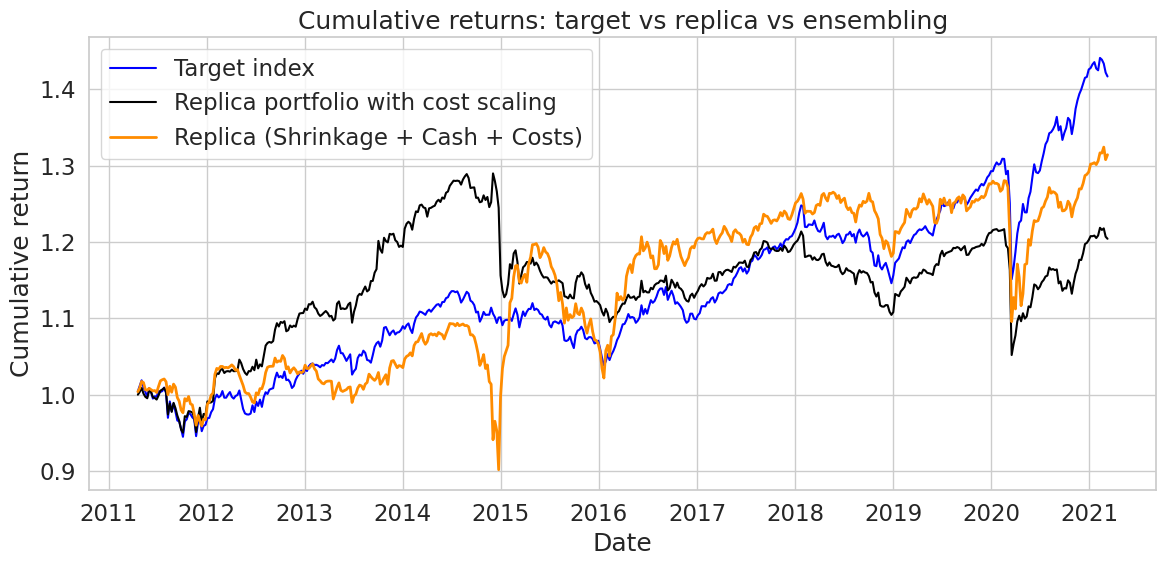

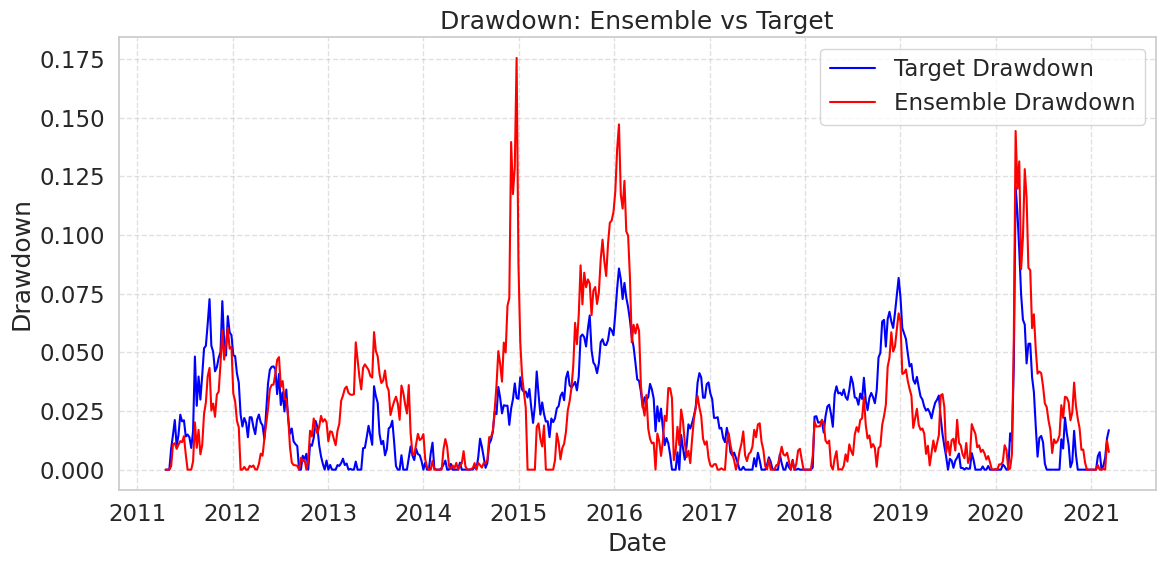

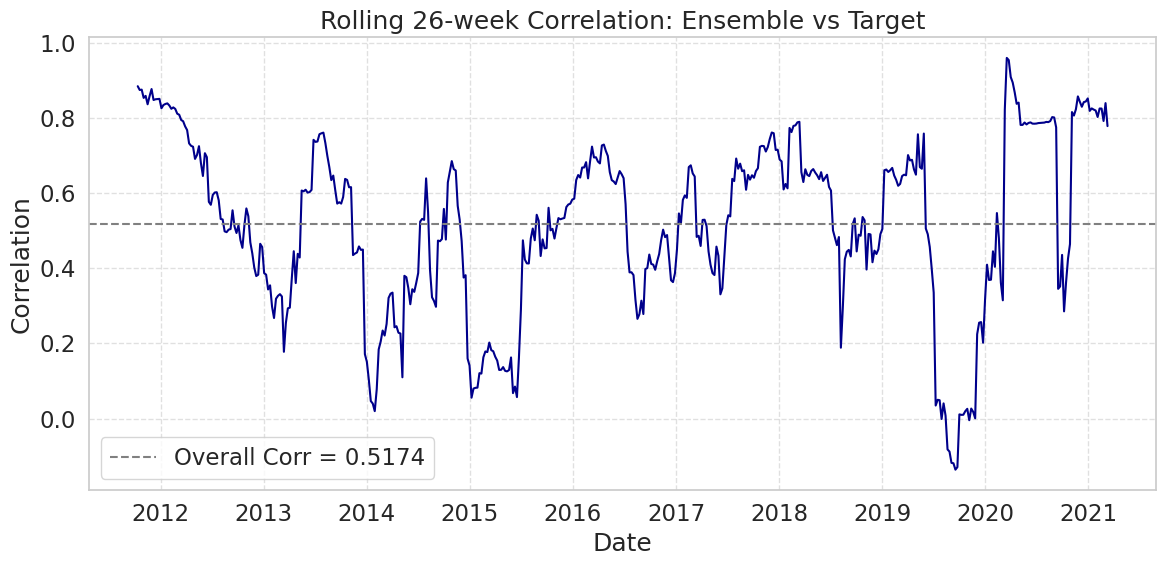

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Align series ===
ensemble_returns = r_total
target_aligned   = target_returns.loc[ensemble_returns.index]

# === Cumulative returns ===
cum_ens    = (1 + ensemble_returns).cumprod()
cum_target = (1 + target_aligned).cumprod()

# === Performance metrics ===
mean_ens      = ensemble_returns.mean() * 52
mean_target   = target_aligned.mean() * 52
vol_ens       = ensemble_returns.std() * np.sqrt(52)
vol_target    = target_aligned.std() * np.sqrt(52)
sharpe_ens    = mean_ens / vol_ens if vol_ens > 0 else 0
sharpe_target = mean_target / vol_target if vol_target > 0 else 0
tracking_err  = (ensemble_returns - target_aligned).std() * np.sqrt(52)
info_ratio    = (mean_ens - mean_target) / tracking_err if tracking_err > 0 else 0
corr          = ensemble_returns.corr(target_aligned)
drawdown_ens  = 1 - cum_ens / cum_ens.cummax()
drawdown_target = 1 - cum_target / cum_target.cummax()
max_dd_ens    = drawdown_ens.max()

# === Tabella performance ===
performance_table = pd.DataFrame({
    "Metric": [
        "Annualized Return", "Annualized Volatility", "Sharpe Ratio",
        "Tracking Error", "Information Ratio", "Max Drawdown", "Correlation"
    ],
    "Ensemble": [
        f"{mean_ens*100:.2f}%", f"{vol_ens*100:.2f}%", f"{sharpe_ens:.2f}",
        f"{tracking_err*100:.2f}%", f"{info_ratio:.2f}", f"{max_dd_ens*100:.2f}%", f"{corr:.4f}"
    ]
})
display(performance_table)

# Plot cumulative returns Beta No Costs - Beta Costs
plt.figure(figsize=(12, 6))
plt.plot(best_kf['cumulative_target'], label='Target index', color='blue')
plt.plot(adapted['cumulative_replica'], label='Replica portfolio with cost scaling', color='black')
plt.plot(cum_replica, label='Replica (Shrinkage + Cash + Costs)', color='darkorange', linewidth=2)
plt.title('Cumulative returns: target vs replica vs ensembling')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Drawdown Plot ===
plt.figure(figsize=(12, 6))
plt.plot(drawdown_target, label='Target Drawdown', color='blue')
plt.plot(drawdown_ens,    label='Ensemble Drawdown', color='red')
plt.title('Drawdown: Ensemble vs Target')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# === Rolling Correlation Plot (26 weeks) ===
rolling_corr = ensemble_returns.rolling(26).corr(target_aligned)
plt.figure(figsize=(12, 6))
plt.plot(rolling_corr, color='darkblue')
plt.axhline(y=corr, linestyle='--', color='gray', label=f'Overall Corr = {corr:.4f}')
plt.title('Rolling 26-week Correlation: Ensemble vs Target')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## **Pair Trading Strategy Based on Kalman Filter Portfolio Replicators**



### **Context: Kalman-Based Pair Trading Strategy Using Portfolio Replicators**

This section implements a **statistical arbitrage strategy** based on the idea that two distinct portfolios—each constructed to replicate the same financial index—may temporarily **diverge in performance** due to differences in their composition. When this divergence becomes statistically significant, a **mean-reverting trading strategy** is applied, aiming to exploit the convergence that is expected to follow.

---

### **Core Idea**

Two Kalman Filter-based portfolio replicators are built using **different sets of assets**. Though both are optimized to mimic the same target index, the fact that they rely on different information sets means their realized returns may **deviate** over time, despite a shared long-term objective.

This temporary deviation measured through metrics like rolling correlation and spread—serves as the foundation for a **pair trading strategy**: when the correlation between the two portfolios drops below a defined threshold, it signals a dislocation that can be traded.

---

### **Mechanics of the Strategy**

1. **Portfolio Construction**:
   Two separate Kalman Filter models are trained on **non-overlapping subsets** of the asset universe. Each Kalman Filter dynamically adjusts the weights of its respective portfolio to replicate a common benchmark (e.g., an index or a synthetic target return).

2. **Signal Generation**:
   The **rolling correlation** between the two portfolios’ returns is computed over a fixed time window. A drop in this correlation suggests that the portfolios are no longer moving in sync—indicating a **temporary mispricing**.

3. **Trading Logic**:
   When this dislocation is detected, a position is opened:

   * **Long the underperforming portfolio** and
   * **Short the outperforming portfolio**.
     The assumption is that the two portfolios will **converge back** due to their common tracking objective.

4. **Exit Criteria**:
   The position is closed when correlation rises again—signaling **mean reversion** or restored synchronicity.

5. **Return Construction**:
   The return from the strategy is derived from the **spread between the two portfolios** during the holding period, adjusted for position direction.

---

### **Performance Evaluation**

The strategy's effectiveness is evaluated in terms of:

* **Cumulative returns** (how profitable the strategy is over time),
* **Sharpe Ratio** (risk-adjusted performance), and
* **Comparison with individual replicators and the target index**.

This allows us to assess whether the trading signals derived from **correlation-based dislocations** actually produce **positive alpha** when executed systematically.

---

### **Why This Approach Is Meaningful**

* **Diversification in Replication**: By constructing multiple independent replicators of the same target using different inputs, one generates naturally occurring divergences that wouldn't exist in a single portfolio.
* **Model-Based Arbitrage**: Instead of relying on two individual assets, this approach uses **model-driven synthetic portfolios**, potentially making the arbitrage signal more stable and robust.
* **Risk-Neutral Execution**: The long/short nature of the trade, where total exposure is balanced between two similar portfolios, allows for **market neutrality**, reducing sensitivity to broad market movements.



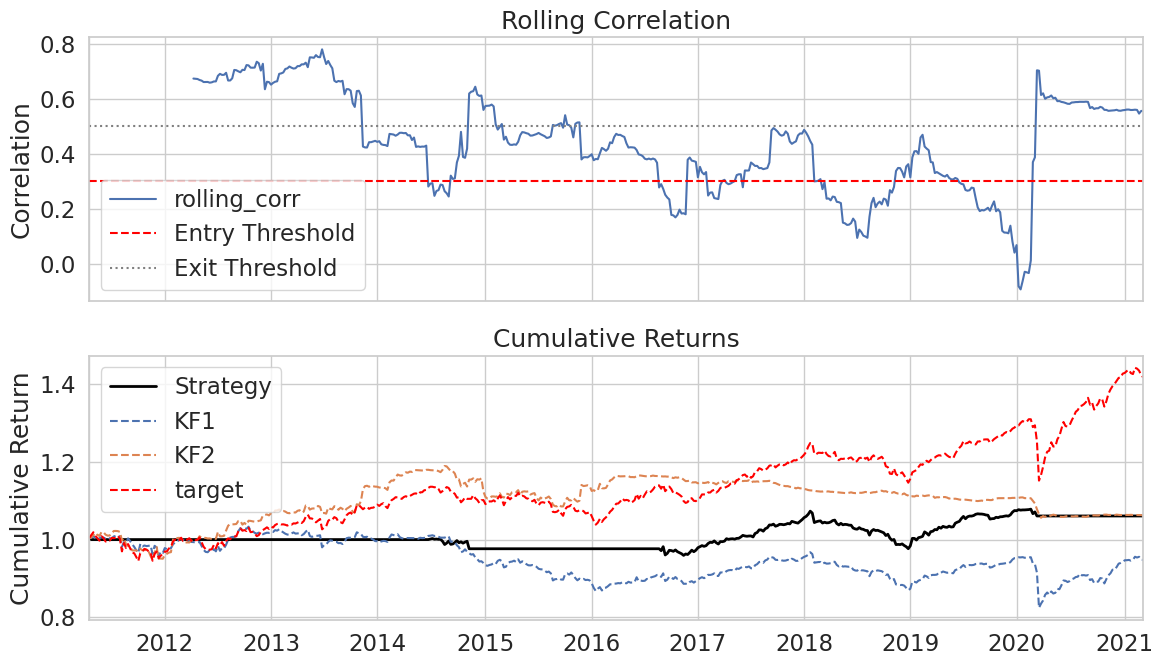

Annualized Sharpe: 0.27


In [25]:
X_1 = X_values[:, :5]
X_2 = X_values[:, 5:]
X_values = X_1
kf_1 = run_kf_Beta_Costs(best_metrics['l1_ratio'], best_metrics['rolling_window'], best_metrics['alpha'], best_metrics['Q'], best_metrics['R'], best_metrics['beta_window'], 0.05, 0.0000)
X_values = X_2
kf_2 = run_kf_Beta_Costs(best_metrics['l1_ratio'], best_metrics['rolling_window'], best_metrics['alpha'], best_metrics['Q'], best_metrics['R'], best_metrics['beta_window'], 0.05, 0.0000)


# --- Base DataFrame ---
df = pd.DataFrame({
    'kf1': kf_1['replica_returns'],
    'kf2': kf_2['replica_returns'],
    'target': kf_1['cumulative_target']
}).dropna()

# --- Parameters ---
window = 52
entry_threshold = 0.3  # Enter trade when correlation drops below this
exit_threshold = 0.5   # Exit trade when correlation rises above this

# --- Rolling Metrics ---
df['spread'] = df['kf1'] - df['kf2']
df['rolling_corr'] = df['kf1'].rolling(window).corr(df['kf2'])

# --- Strategy Logic ---
position = 0
positions = []

# Compute cumulative returns before loop
df['kf1_cum'] = df['kf1'].cumsum()
df['kf2_cum'] = df['kf2'].cumsum()

for i in range(len(df)):
    corr = df['rolling_corr'].iloc[i]
    kf1_ret = df['kf1'].iloc[i]
    kf2_ret = df['kf2'].iloc[i]

    # Entry condition
    if position == 0 and corr < entry_threshold:
        position = 1 if df['kf1_cum'].iloc[i] < df['kf2_cum'].iloc[i] else -1
    # Exit condition
    elif position != 0 and corr > exit_threshold:
        position = 0

    positions.append(position)

df['signal'] = positions
df['strategy_ret'] = df['signal'].shift(1) * df['spread']

 # --- Cumulative Returns ---
df['kf1_cum'] = (1 + df['kf1']).cumprod()
df['kf2_cum'] = (1 + df['kf2']).cumprod()
df['cum_strategy'] = (1 + df['strategy_ret']).cumprod()

# --- Plotting ---
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# Plot rolling correlation
df['rolling_corr'].plot(ax=axes[0], title='Rolling Correlation')
axes[0].axhline(entry_threshold, color='red', linestyle='--', label='Entry Threshold')
axes[0].axhline(exit_threshold, color='gray', linestyle=':', label='Exit Threshold')
axes[0].set_ylabel("Correlation")
axes[0].legend()

# Plot strategy and model cumulative returns
df['cum_strategy'].plot(ax=axes[1], label='Strategy', color='black', linewidth=2)
df['kf1_cum'].plot(ax=axes[1], label='KF1', linestyle='--')
df['kf2_cum'].plot(ax=axes[1], label='KF2', linestyle='--')
df['target'].plot(ax=axes[1], label='target', color = 'red', linestyle='--')
axes[1].set_ylabel("Cumulative Return")
axes[1].set_title("Cumulative Returns")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Sharpe Ratio ---
sharpe = df['strategy_ret'].mean() / df['strategy_ret'].std() * np.sqrt(52)
print(f"Annualized Sharpe: {sharpe:.2f}")